In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
#from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

#import warnings
#warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-Yogi
Time: Mon Nov 16 08:55:59 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14261,id_a6a4f3626,trt_cp,24,D2,-0.3265,0.1577,-0.3381,0.1789,0.2595,0.7117,...,0,0,0,0,0,0,0,0,0,0
14266,id_a6b456ebb,trt_cp,24,D1,-0.7239,0.0713,0.2250,0.5864,2.6280,-0.4762,...,0,0,0,0,0,0,0,0,0,0
5119,id_3bd739795,trt_cp,24,D1,0.5283,1.2350,2.7150,-0.0206,0.5865,0.2824,...,0,0,0,0,0,0,0,0,0,0
692,id_07b7426b2,trt_cp,24,D1,-0.2856,-0.6573,1.8890,-0.3083,-0.5899,0.5369,...,0,0,0,0,0,0,0,0,0,0
6833,id_4fbf1ada4,trt_cp,72,D2,0.9492,-0.5027,-0.0934,-2.2830,-0.1903,0.0230,...,0,0,0,0,0,0,0,0,0,0
7051,id_52620ac73,trt_cp,24,D1,-0.4717,-0.2592,-0.5129,0.0462,0.5863,-0.6585,...,0,0,0,0,0,0,0,0,0,0
13131,id_995a3b2d4,trt_cp,48,D1,2.4190,-1.1380,-0.4596,-0.1602,2.5480,1.5230,...,0,0,0,0,0,0,0,0,0,0
2435,id_1c33757b3,trt_cp,24,D1,-0.0171,-0.0432,-0.4036,-0.6486,-0.7183,-0.5947,...,0,0,0,0,0,0,0,0,0,0
10021,id_7514b50fb,trt_cp,48,D1,0.5772,0.8006,1.5080,-0.8161,-0.1879,-0.1965,...,0,0,0,0,0,0,0,0,0,0
13768,id_a0ad27715,trt_cp,48,D2,0.2120,0.2485,1.0300,-1.0730,-0.0180,-1.7210,...,0,0,0,0,0,0,0,0,0,0


# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 3e-3
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer as optim

In [15]:
from torch.optim import lr_scheduler

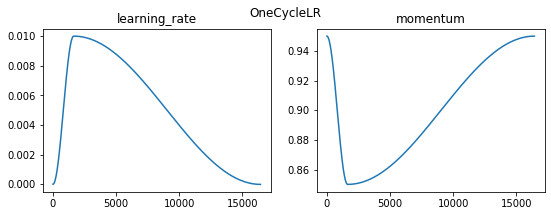

In [16]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = optim.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'pct_start': 0.1,
    'div_factor': 1e3,
    'max_lr': 1e-2,
    'epochs': CFG.epochs,
    'pct_start':0.1,
    'final_div_factor':10000.0,
    'steps_per_epoch': len(trn_loader)
}
CFG.scheduler = lr_scheduler.OneCycleLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# train

In [17]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [18]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.635760,0.6356753708,0.078446,0.0777687537,0:8
2,0.030967,0.0297070571,0.021773,0.0202655877,0:7
3,0.022665,0.0210881864,0.020529,0.0189013309,0:7
4,0.021551,0.0199079876,0.019750,0.0180841614,0:7
5,0.020840,0.0191779781,0.019352,0.0176453607,0:7
6,0.020349,0.0186678365,0.019127,0.0174287996,0:7
7,0.019957,0.0182714172,0.018910,0.0172076107,0:7
8,0.019676,0.0179805106,0.018733,0.0170160799,0:7
9,0.019342,0.0176366827,0.018700,0.0169648762,0:7
10,0.019046,0.0173315991,0.018529,0.0168072380,0:7


epoch1 save best model... 0.07776875366925651
epoch2 save best model... 0.020265587732399514
epoch3 save best model... 0.01890133094712922
epoch4 save best model... 0.018084161418886826
epoch5 save best model... 0.0176453606965941
epoch6 save best model... 0.0174287995836933
epoch7 save best model... 0.01720761071746333
epoch8 save best model... 0.017016079892024635
epoch9 save best model... 0.016964876179950385
epoch10 save best model... 0.016807237974365914
epoch11 save best model... 0.016708947211537924
epoch12 save best model... 0.01660622133022696
epoch13 save best model... 0.01656327099371744
epoch14 save best model... 0.016541878381799185
epoch15 save best model... 0.016424472805681153
epoch16 save best model... 0.016411632206927398
epoch17 save best model... 0.016354828481488184
epoch18 save best model... 0.016324127097200426
epoch19 save best model... 0.0162841025812038
epoch20 save best model... 0.01625150046046136
epoch21 save best model... 0.016229830721736904
epoch23 save 

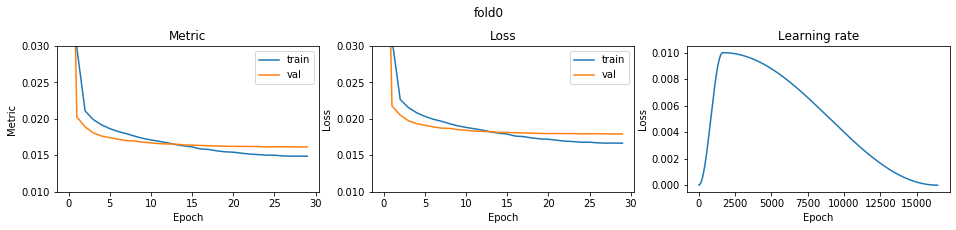

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.637104,0.6370203114,0.077527,0.0768565837,0:7
2,0.031176,0.0299148288,0.022017,0.0205163437,0:6
3,0.022541,0.0209615365,0.020833,0.0191991287,0:6
4,0.021378,0.0197358985,0.019852,0.0182189679,0:7
5,0.020904,0.0192367074,0.019611,0.0179198067,0:6
6,0.020314,0.0186289401,0.019189,0.0175143928,0:6
7,0.019884,0.0181913775,0.019184,0.0175065933,0:6
8,0.019569,0.0178712728,0.019032,0.0173364366,0:6
9,0.019263,0.0175586671,0.018875,0.0171733400,0:7
10,0.018974,0.0172609379,0.018783,0.0170715476,0:6


epoch1 save best model... 0.07685658368957861
epoch2 save best model... 0.02051634368893904
epoch3 save best model... 0.019199128722524585
epoch4 save best model... 0.018218967927363907
epoch5 save best model... 0.01791980673933958
epoch6 save best model... 0.017514392769647013
epoch7 save best model... 0.01750659333288629
epoch8 save best model... 0.01733643664155341
epoch9 save best model... 0.01717333998857883
epoch10 save best model... 0.01707154761479544
epoch11 save best model... 0.016947252098296926
epoch13 save best model... 0.01681762571790565
epoch14 save best model... 0.016733484980975964
epoch15 save best model... 0.01668941105108417
epoch16 save best model... 0.016651225574424937
epoch17 save best model... 0.016586458330006798
epoch19 save best model... 0.01655897383184925
epoch20 save best model... 0.01654080974774579
epoch21 save best model... 0.016539395934933747
epoch22 save best model... 0.016534642062191744
epoch23 save best model... 0.016488294448600824
epoch24 save

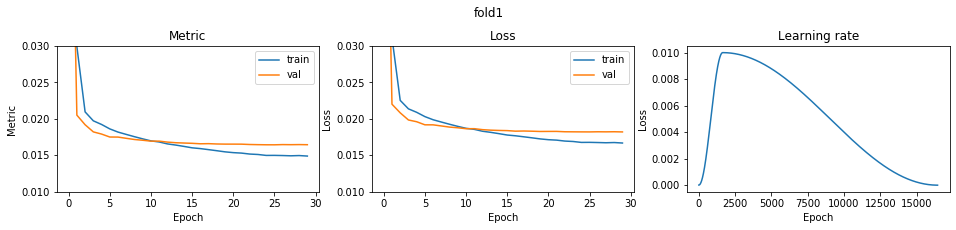

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.633379,0.6332928467,0.077303,0.0766183125,0:6
2,0.031006,0.0297449453,0.022029,0.0205002571,0:6
3,0.022669,0.0210870828,0.020691,0.0190607966,0:7
4,0.021599,0.0199589882,0.020072,0.0184031352,0:7
5,0.020976,0.0193093212,0.019487,0.0178075696,0:6
6,0.020469,0.0187892897,0.019373,0.0176738215,0:6
7,0.019999,0.0183099359,0.019071,0.0173894067,0:7
8,0.019765,0.0180718993,0.018878,0.0171565819,0:7
9,0.019398,0.0176916676,0.018698,0.0170005523,0:7
10,0.019163,0.0174550179,0.018600,0.0169099143,0:7


epoch1 save best model... 0.07661831252468722
epoch2 save best model... 0.020500257135109792
epoch3 save best model... 0.01906079660798089
epoch4 save best model... 0.018403135243897476
epoch5 save best model... 0.017807569595401366
epoch6 save best model... 0.017673821542025847
epoch7 save best model... 0.017389406701331326
epoch8 save best model... 0.017156581909370926
epoch9 save best model... 0.017000552313731196
epoch10 save best model... 0.016909914261833983
epoch11 save best model... 0.016824790358494168
epoch12 save best model... 0.016706035831061696
epoch13 save best model... 0.01664465299781389
epoch14 save best model... 0.016559466431254773
epoch15 save best model... 0.016534877850829632
epoch16 save best model... 0.016476897872504
epoch17 save best model... 0.016455933516584108
epoch18 save best model... 0.016432886125847077
epoch19 save best model... 0.016378815741655724
epoch20 save best model... 0.016364873197854013
epoch22 save best model... 0.016345149205306254
epoch23

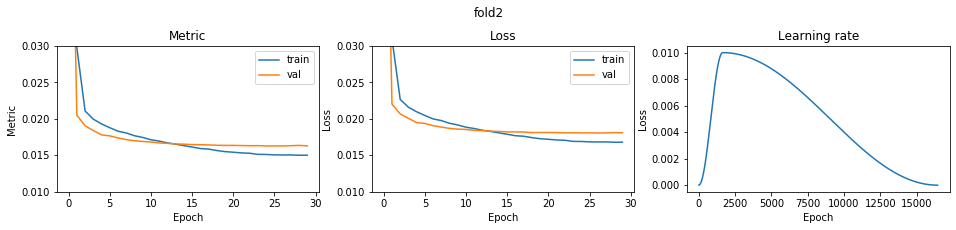

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.630564,0.6304750909,0.076461,0.0757859843,0:6
2,0.030946,0.0296847058,0.022007,0.0204830245,0:7
3,0.022527,0.0209484971,0.020576,0.0189544968,0:6
4,0.021271,0.0196328107,0.019862,0.0182092800,0:6
5,0.020679,0.0190166893,0.019541,0.0178596855,0:6
6,0.020201,0.0185229829,0.019384,0.0177023186,0:6
7,0.019819,0.0181292700,0.019101,0.0174101170,0:6
8,0.019472,0.0177711373,0.018960,0.0172559956,0:7
9,0.019166,0.0174560585,0.018840,0.0171365327,0:6
10,0.018981,0.0172624876,0.018731,0.0170087040,0:6


epoch1 save best model... 0.07578598427541706
epoch2 save best model... 0.020483024504909755
epoch3 save best model... 0.018954496844279196
epoch4 save best model... 0.018209280004483012
epoch5 save best model... 0.017859685461297802
epoch6 save best model... 0.01770231861935118
epoch7 save best model... 0.01741011704494307
epoch8 save best model... 0.01725599559613743
epoch9 save best model... 0.017136532677112654
epoch10 save best model... 0.017008703952583068
epoch11 save best model... 0.01689359633536301
epoch12 save best model... 0.01686584988146477
epoch13 save best model... 0.016799796860164418
epoch14 save best model... 0.01675565741353738
epoch15 save best model... 0.016676566543180605
epoch16 save best model... 0.016614790696540427
epoch17 save best model... 0.016585088200052535
epoch18 save best model... 0.016528010817248893
epoch19 save best model... 0.016505654017040017
epoch20 save best model... 0.01645089350513486
epoch22 save best model... 0.016440565332532745
epoch23 s

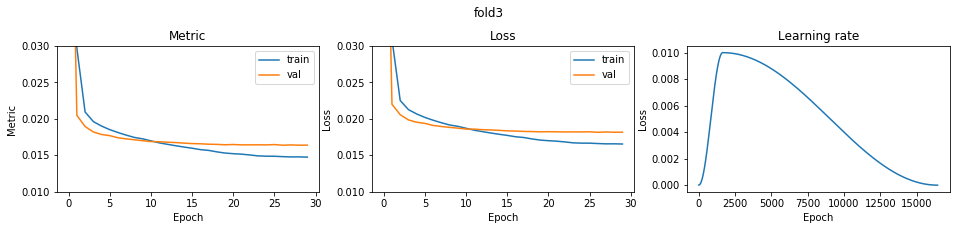

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.630636,0.6305472097,0.079330,0.0786557406,0:5
2,0.031294,0.0300346857,0.021784,0.0202775371,0:6
3,0.022784,0.0212082839,0.020379,0.0187623982,0:5
4,0.021644,0.0200025318,0.019688,0.0180332484,0:4
5,0.020773,0.0191105318,0.019323,0.0176643051,0:3
6,0.020267,0.0185865700,0.019117,0.0174451795,0:4
7,0.019910,0.0182173359,0.019014,0.0173438011,0:4
8,0.019595,0.0178978330,0.018838,0.0171295370,0:4
9,0.019294,0.0175854707,0.018721,0.0170234936,0:4
10,0.019056,0.0173434318,0.018621,0.0169237878,0:4


epoch1 save best model... 0.07865574056100194
epoch2 save best model... 0.020277537077088292
epoch3 save best model... 0.018762398203983392
epoch4 save best model... 0.018033248355404256
epoch5 save best model... 0.017664305075307234
epoch6 save best model... 0.017445179531965956
epoch7 save best model... 0.01734380111361351
epoch8 save best model... 0.017129536952339708
epoch9 save best model... 0.017023493602006338
epoch10 save best model... 0.01692378778935565
epoch11 save best model... 0.016811437808520294
epoch12 save best model... 0.016754121668976232
epoch13 save best model... 0.01667299392486759
epoch14 save best model... 0.016612253799729033
epoch15 save best model... 0.01658838797734036
epoch16 save best model... 0.01652435845141734
epoch17 save best model... 0.01650223236250986
epoch18 save best model... 0.016483609983803608
epoch19 save best model... 0.016428705523371834
epoch21 save best model... 0.01635851264212085
epoch24 save best model... 0.016343989328042114
epoch27 s

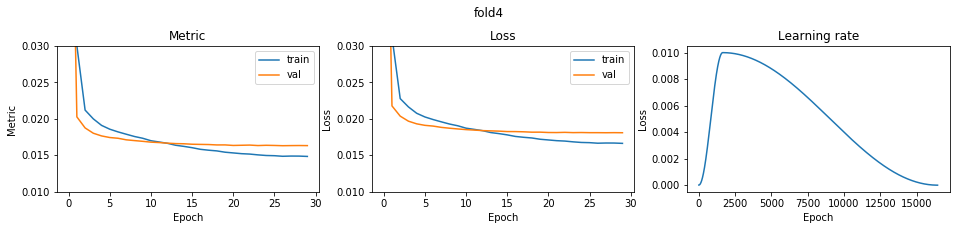

CV score: 0.016318729747994084


In [19]:
oof, predictions = run_kfold_nn(CFG, trn_df, test_df, CFG.feature_cols, CFG.target_cols, n_fold=5)

In [20]:
# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
logger.info(f"OOF result: {score}")

OOF result: 0.016318729747994136


In [21]:
ys = trn_df[y_keys]
trn_df[y_keys] = pd.DataFrame(oof)
trn_df[['sig_id'] + y_keys].to_csv('oof.csv', index=False)

test_df[y_keys] = pd.DataFrame(predictions)
test_df[['sig_id'] + y_keys].to_csv('pred.csv', index=False)

In [22]:
# Final result with 'cp_type'=='ctl_vehicle' data
result = trn_tar_df.drop(columns=y_keys).merge(trn_df[['sig_id']+y_keys], on='sig_id', how='left').fillna(0)

ys = trn_tar_df[y_keys].values
preds = result[y_keys].values

score = compute_metric(preds, ys)
logger.info(f"Final result: {score}")

Final result: 0.015040038654109938


In [23]:
sub = sub_df.drop(columns=y_keys).merge(test_df[['sig_id'] + y_keys], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001071,0.001513,0.001620,0.015931,0.027967,0.004957,0.002414,0.005225,0.000257,...,0.000827,0.000887,0.003439,0.000436,0.000468,0.000769,0.000311,0.002125,0.003805,0.001542
1,id_001897cda,0.000303,0.001315,0.001506,0.001873,0.001527,0.001600,0.002248,0.007311,0.007696,...,0.000462,0.001525,0.002541,0.000201,0.008142,0.000882,0.004315,0.000720,0.001949,0.001463
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000513,0.000772,0.001571,0.008077,0.009764,0.002931,0.001940,0.005043,0.000291,...,0.000562,0.001323,0.003170,0.010957,0.006466,0.000531,0.003458,0.001591,0.000498,0.001825
4,id_0027f1083,0.001442,0.001484,0.001968,0.011923,0.021371,0.004908,0.004777,0.002332,0.000340,...,0.000615,0.000639,0.005999,0.002671,0.000807,0.000532,0.001531,0.002085,0.000286,0.001472
